In [3]:
!pip install kagglehub

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [5]:
dataset_path = kagglehub.dataset_download(
    "birdy654/cifake-real-and-ai-generated-synthetic-images"
)

train_dir = os.path.join(dataset_path, "train")
test_dir  = os.path.join(dataset_path, "test")

print("Dataset Path:", dataset_path)
print("Classes:", os.listdir(train_dir))

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Dataset Path: /kaggle/input/cifake-real-and-ai-generated-synthetic-images
Classes: ['FAKE', 'REAL']


In [6]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

full_train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = full_train_dataset.classes
print("Class Names:", class_names)

Class Names: ['FAKE', 'REAL']


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Using Device: cuda


In [7]:
def evaluate(model, loader):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss_total += loss.item()
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return loss_total/len(loader), correct/total


def train_model(model, epochs=8):
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_loss, val_acc = evaluate(model, val_loader)
        scheduler.step()

        print(f"Epoch {epoch+1}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    print("Training Complete")

train_model(model)

KeyboardInterrupt: 

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.89      0.88      0.88     10000
        REAL       0.88      0.89      0.89     10000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



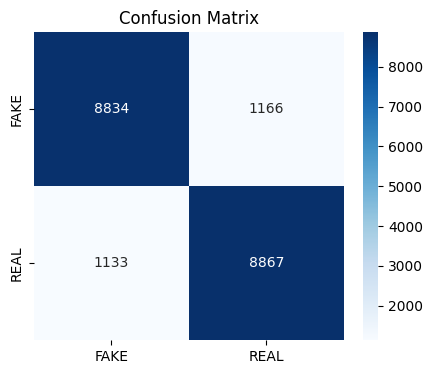

In [8]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# 🔥 Enable gradients for Grad-CAM
for param in model.parameters():
    param.requires_grad = True

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
from PIL import Image
import random

In [17]:
# ─── Modern Grad-CAM class with full_backward_hook (safer) ────────────────

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        # Use full_backward_hook (more reliable in newer PyTorch)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, inp, out):
        self.activations = out.detach()

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x, target_class=None):
        self.model.eval()
        logit = self.model(x)

        if target_class is None:
            target_class = logit.argmax(dim=1).item()

        score = logit[0, target_class]
        self.model.zero_grad()
        score.backward()

        if self.gradients is None or self.activations is None:
            raise RuntimeError("Gradients or activations not captured – check hooks")

        grads = self.gradients[0]           # shape: C,H,W
        acts  = self.activations[0]         # shape: C,H,W

        weights = grads.mean(dim=(1,2), keepdim=True)   # Global Average Pool → C,1,1
        cam = (weights * acts).sum(dim=0).relu()        # H,W
        cam = cam / (cam.max() + 1e-8)
        return cam


# ─── Fixed visualization function ─────────────────────────────────────────

def show_gradcam_four_images():
    samples = get_four_samples(test_dir)
    if not samples:
        return

    print("\nSelected images for Grad-CAM visualization:")
    for p, c in samples:
        print(f"  • {os.path.basename(p):<20}  (True: {c})")

    # Ensure gradients are enabled
    for param in model.parameters():
        param.requires_grad = True

    model.eval()

    target_layer = model.layer4[-1].conv2
    gradcam = GradCAM(model, target_layer)

    fig, axes = plt.subplots(4, 3, figsize=(12, 14))
    fig.suptitle("Grad-CAM Explanations – TRUE vs PREDICTED", fontsize=16, y=0.98)

    for i, (img_path, true_label) in enumerate(samples):

        if not os.path.isfile(img_path):
            print(f"Missing file: {img_path}")
            continue

        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)

        # 🔥 Get prediction (NO torch.no_grad here!)
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()

        # Convert numeric prediction to label name
        pred_label = class_names[pred_class]

        # Generate Grad-CAM using predicted class
        cam = gradcam(input_tensor, target_class=pred_class)

        cam_np = cam.detach().cpu().numpy()
        cam_np = np.maximum(cam_np, 0)
        cam_np = cam_np / (cam_np.max() + 1e-8)

        # Resize CAM
        cam_resized = np.array(
            Image.fromarray(cam_np).resize((224, 224), Image.BILINEAR)
        )

        cmap = plt.get_cmap('jet')
        heatmap = cmap(cam_resized)[:, :, :3]

        img_resized = np.array(img.resize((224, 224))) / 255.0
        overlay = (0.40 * heatmap + 0.60 * img_resized).clip(0, 1)

        # Plot Original
        axes[i,0].imshow(img_resized)
        axes[i,0].set_title(f"Original\nTrue: {true_label}\nPred: {pred_label}")
        axes[i,0].axis('off')

        # Plot Heatmap
        axes[i,1].imshow(heatmap)
        axes[i,1].set_title("Grad-CAM Heatmap")
        axes[i,1].axis('off')

        # Plot Overlay
        axes[i,2].imshow(overlay)
        axes[i,2].set_title("Overlay")
        axes[i,2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Remove hooks after visualization
    gradcam = None


Selected images for Grad-CAM visualization:
  • 0000 (10).jpg         (True: REAL)
  • 0000 (2).jpg          (True: REAL)
  • 380 (9).jpg           (True: FAKE)
  • 569 (10).jpg          (True: FAKE)


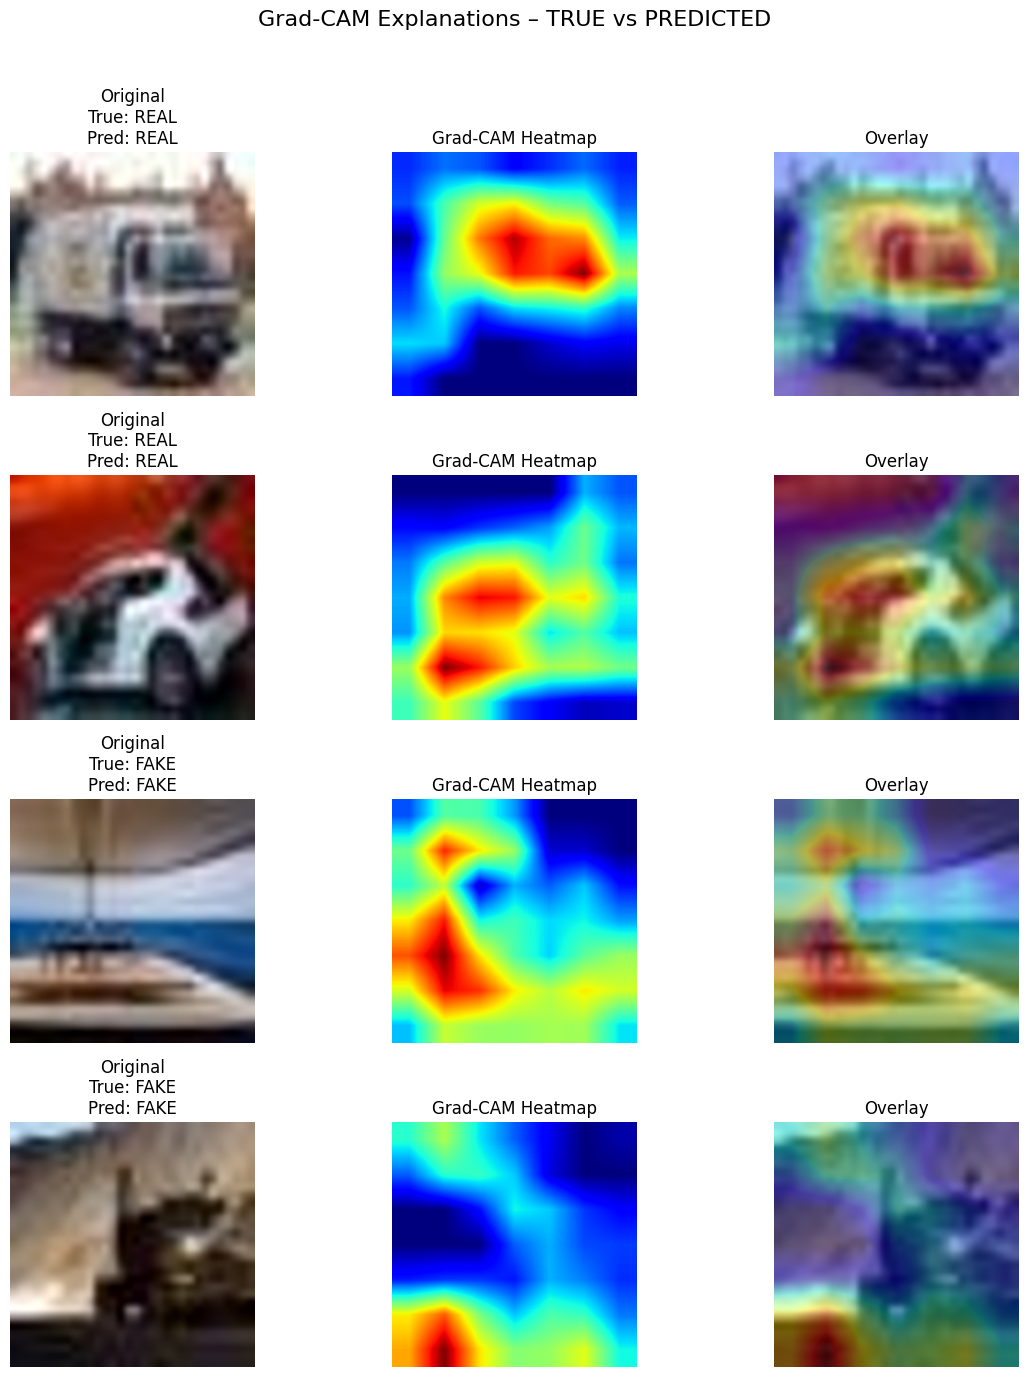

In [19]:
model.eval()
show_gradcam_four_images()